## 1. Instalaciones necesarias

In [ ]:
! pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 22.6 MB/s eta 0:00:00


In [ ]:
import os, sys
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import pydicom
import time
import cv2
import keras
from PIL import Image
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet121, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU,RandomFlip,RandomContrast,RandomBrightness, UpSampling2D,add, Input, Conv2D, Activation, Flatten, RandomRotation, RandomZoom, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, concatenate, Reshape, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import BinaryIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from PIL import ImageFont
# Ruta a la fuente
font_path = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"
random.seed(42)
import visualkeras


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Leer los datos

In [ ]:
main_dir = '/content/drive/MyDrive/0tfm/RSNA/'

lables = 'stage_2_train_labels.csv'
lables_full = 'stage_2_detailed_class_info.csv'
images="stage_2_train_images/"


lables_dir = main_dir + lables
lables_full_dir = main_dir + lables_full
images_dir = main_dir + images
images_dir_png = main_dir + 'converted_to_png_images/'
mask_dir_png = main_dir + 'converted_to_png_mask/'
dataset_agrupado_dir =main_dir + "df_coordinates_listed.csv"

df_train_val= pd.read_csv(main_dir +"df_train_balanced.csv")
df_test= pd.read_csv(main_dir +"df_test_balanced.csv")

scaler = MinMaxScaler()
# Normaliza las variables numéricas en el conjunto de entrenamiento + validación
df_train_val[['PatientAge']] = scaler.fit_transform(df_train_val[['PatientAge']])
# Normaliza las variables numéricas en el conjunto de prueba utilizando los parámetros del entrenamiento
df_test[['PatientAge']] = scaler.transform(df_test[['PatientAge']])

df_train, df_val= train_test_split(df_train_val, test_size=0.2,stratify=df_train_val["Target"], random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print("df_train",df_train.shape)
print("df_val", df_val.shape)
print("df_test", df_test.shape)

df_train (9122, 8)
df_val (2281, 8)
df_test (601, 8)


 generador de datos personalizado

In [ ]:
image_size=224

# Función para cargar imágenes
def load_image(image_path, new_size=(image_size, image_size), augmentation=0):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

      # Redimensionar la imagen
    image = tf.image.resize(image, new_size)

        # Normalizar la imagen
    image = tf.cast(image, tf.float32) / 255.0  # Escalar a [0, 1]

    return image


In [ ]:
batch_size=32

#para train
image_paths_train = images_dir_png+  df_train["filename"]  # Rutas a las imágenes de train
mask_paths_train = mask_dir_png + df_train["filename_masc"]  # Rutas a las máscaras de train
variables_num_train = df_train[["PatientAge","PatientSex","ViewPosition"]].values  # Variables adicionales de train
target_train = df_train['Target'].values   # Objetivo binario de train

#para val
image_paths_val = images_dir_png +  df_val["filename"]  # Rutas a las imágenes de train
mask_paths_val = mask_dir_png + df_val["filename_masc"]  # Rutas a las máscaras de train
variables_num_val = df_val[["PatientAge","PatientSex","ViewPosition"]].values  # Variables adicionales de train
target_val = df_val['Target'].values   # Objetivo binario de train

#para test
image_paths_test = images_dir_png +  df_test["filename"]  # Rutas a las imágenes de train
mask_paths_test= mask_dir_png + df_test["filename_masc"]  # Rutas a las máscaras de train
variables_num_test = df_test[["PatientAge","PatientSex","ViewPosition"]].values  # Variables adicionales de test
target_test= df_test['Target'].values  # Objetivo binario de test


 sin mascara

In [ ]:
train_dataset_sin_mascara = tf.data.Dataset.from_tensor_slices((image_paths_train, target_train))
train_dataset_sin_mascara = train_dataset_sin_mascara.map(lambda img_path,target:
                                    (load_image(img_path, augmentation=0),  # Entrada: imagen y variables
                                    target))  # Salida: solo target
train_dataset_sin_mascara = train_dataset_sin_mascara.shuffle(buffer_size=5000)
train_dataset_sin_mascara = train_dataset_sin_mascara.batch(batch_size)
train_dataset_sin_mascara = train_dataset_sin_mascara.repeat()  # Repetir indefinidamente
train_dataset_sin_mascara = train_dataset_sin_mascara.prefetch(tf.data.AUTOTUNE)  # Optimizar la carga de datos

# Dataset de val
val_dataset_sin_mascara = tf.data.Dataset.from_tensor_slices((image_paths_val, target_val))
val_dataset_sin_mascara = val_dataset_sin_mascara.map(lambda img_path,  target:
                                (load_image(img_path,  augmentation=0),  # Entrada: imagen y variables
                                  target))  # Salida:  target
val_dataset_sin_mascara = val_dataset_sin_mascara.batch(batch_size)
val_dataset_sin_mascara = val_dataset_sin_mascara.repeat()  # Repetir indefinidamente
val_dataset_sin_mascara = val_dataset_sin_mascara.prefetch(tf.data.AUTOTUNE)


test_dataset_sin_mascara = tf.data.Dataset.from_tensor_slices((image_paths_test, target_test))
test_dataset_sin_mascara = test_dataset_sin_mascara.map(lambda img_path,  target:
                                (load_image(img_path,  augmentation=0),  # Entrada: imagen y variables
                                  target))  # Salida:  target
test_dataset_sin_mascara = test_dataset_sin_mascara.batch(batch_size)
test_dataset_sin_mascara = test_dataset_sin_mascara.prefetch(tf.data.AUTOTUNE)

sin mascara con var num

In [ ]:
# Dataset de entrenamiento
train_dataset_num_var = tf.data.Dataset.from_tensor_slices((image_paths_train, variables_num_train, target_train))
train_dataset_num_var = train_dataset_num_var.map(lambda img_path, var, target:
                                  ((load_image(img_path, augmentation=0), var),  # Entrada: imagen y variables
                                   target))  # Salida: máscara y target
train_dataset_num_var = train_dataset_num_var.shuffle(buffer_size=1000)
train_dataset_num_var = train_dataset_num_var.batch(batch_size)
train_dataset_num_var = train_dataset_num_var.repeat()  # Repetir indefinidamente para evitar quedarse sin datos
train_dataset_num_var = train_dataset_num_var.prefetch(tf.data.AUTOTUNE)  # Optimizar la carga de datos

val_dataset_num_var = tf.data.Dataset.from_tensor_slices((image_paths_val, variables_num_val, target_val))
val_dataset_num_var = val_dataset_num_var.map(lambda img_path, var, target:
                                ((load_image(img_path,  augmentation=0), var),  # Entrada: imagen y variables
                                  target))  # Salida:  target
val_dataset_num_var = val_dataset_num_var.batch(batch_size)
val_dataset_num_var = val_dataset_num_var.repeat()  # Repetir indefinidamente
val_dataset_num_var = val_dataset_num_var.prefetch(tf.data.AUTOTUNE)

test_dataset_num_var = tf.data.Dataset.from_tensor_slices((image_paths_test, variables_num_test, target_test))
test_dataset_num_var = test_dataset_num_var.map(lambda img_path, var, target:
                                ((load_image(img_path,  augmentation=0), var),  # Entrada: imagen y variables
                                  target))  # Salida:  target
test_dataset_num_var = test_dataset_num_var.batch(batch_size)
test_dataset_num_var = test_dataset_num_var.prefetch(tf.data.AUTOTUNE)

 Funciones de utilidad

Visualizar las curvas de aprendizaje (loss y métricas)

In [ ]:
def plot_learning_curves(history, type_g=1):
    # Graficar la pérdida (loss)
    plt.figure(figsize=(12, 4))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()


    # Métricas para la salida de target binario
    plt.subplot(1, 3, 2)
    if type_g == 1:
      plt.plot(history['accuracy'], label='Accuracy de entrenamiento')
      plt.plot(history['val_accuracy'], label='Accuracy de validación')
    elif type_g == 2:
      plt.plot(history['target_output_accuracy'], label='Accuracy de entrenamiento')
      plt.plot(history['val_target_output_accuracy'], label='Accuracy de validación')
    plt.title('Accuracy del target binario')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)

    plt.subplot(1, 3, 3)
    if type_g == 1:
      plt.plot(history.iloc[:,4], label='Accuracy de entrenamiento')
      plt.plot(history.iloc[:,9], label='Accuracy de validación')
      plt.title('Recall del target binario')
      plt.xlabel('Épocas')
      plt.ylabel('recall')
      plt.legend()
      plt.ylim(0, 1)
    elif type_g == 2:
      plt.plot(history.iloc[:,1], label='IoU de entrenamiento')
      plt.plot(history.iloc[:,7], label='IoU de validación')
      plt.title('IoU del target binario')
      plt.xlabel('Épocas')
      plt.ylabel('IoU')
      plt.legend()
      plt.ylim(0, 1)

    plt.show()



 Comparar los modelos

In [ ]:
# Función para extraer métricas de la última época
def extract_last_epoch_metrics(history_df):
    last_epoch = history_df.iloc[-1]
    return {
        'Loss': last_epoch.iloc[7],          # Cambia el índice si es necesario
        'Accuracy': last_epoch.iloc[5],      # Cambia el índice si es necesario
        'Precision': last_epoch.iloc[8],     # Cambia el índice si es necesario
        'Recall': last_epoch.iloc[9],        # Cambia el índice si es necesario
        'AUC': last_epoch.iloc[6]            # Cambia el índice si es necesario
    }

def comparar_modelos(lista_history_files):

    # Lista de archivos de historial
    lista_history_files = lista_history_files
    lista_metrics = []

    # Extraer métricas para cada modelo
    for item in lista_history_files:
        history_df = pd.read_csv(main_dir + "model_training/" + item)
        metrics = extract_last_epoch_metrics(history_df)
        metrics['Model'] = item  # Añadir el nombre del modelo a las métricas
        lista_metrics.append(metrics)

    # Crear un DataFrame a partir de las métricas
    metrics_df = pd.DataFrame(lista_metrics)
    precision = metrics_df["Precision"]
    recall =  metrics_df["Recall"]
    metrics_df["f1_score"] = 2 * (precision * recall) / (precision + recall)

    # Mostrar el DataFrame con las métricas
    print(metrics_df)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7,  # Número de epochs sin mejora antes de detener el entrenamiento
                               restore_best_weights=True)  # Para restaurar los pesos del modelo con la mejor pérdida
# Definir ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,     # Reducir el learning rate en un 20%
                              patience=2,     # Esperar 3 épocas sin mejora
                              min_lr=1e-6)    # No reducir el learning rate por debajo de 1e-6


## Modelos

## 1 Modelos desde cero:

#### CNN2-FromScratch:

In [ ]:
def create_simple_classification_model():
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)


    # Aplanar la salida del encoder para la clasificación
    flatten = GlobalAveragePooling2D()(pool2)  # Aplanar la salida

    # Capas densas para la clasificación
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)  # Salida para clasificación binaria

    # Crear el modelo
    model = Model(inputs=[inputs], outputs=[target_output])

    return model

# Ejemplo de creación del modelo
model = create_simple_classification_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ target_output (Dense)                │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,561 (275.63 KB)

 Trainable params: 70,177 (274.13 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_00_simple_clasif.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_00_simple_clasif.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 81s 188ms/step - accuracy: 0.6348 - auroc: 0.6782 - loss: 0.6401 - precision_8: 0.6230 - recall_8: 0.6812 - val_accuracy: 0.5009 - val_auroc: 0.4190 - val_loss: 1.0165 - val_precision_8: 0.5007 - val_recall_8: 1.0000
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 64s 208ms/step - accuracy: 0.6870 - auroc: 0.7436 - loss: 0.5962 - precision_8: 0.6762 - recall_8: 0.7065 - val_accuracy: 0.4989 - val_auroc: 0.5049 - val_loss: 3.9651 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 63s 220ms/step - accuracy: 0.7144 - auroc: 0.7809 - loss: 0.5634 - precision_8: 0.7056 - recall_8: 0.7461 - val_accuracy: 0.6959 - val_auroc: 0.7742 - val_loss: 0.5842 - val_precision_8: 0.6511 - val_recall_8: 0.8504
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 63s 221ms/step - accuracy: 0.7245 - auroc: 0.7877 - loss: 0.5565 - precision_8: 0.7180 - recall_8: 0.7423 - val_accuracy: 0.5420 - val_auroc: 0.7014 - val_loss: 0.8204 - val_precisi

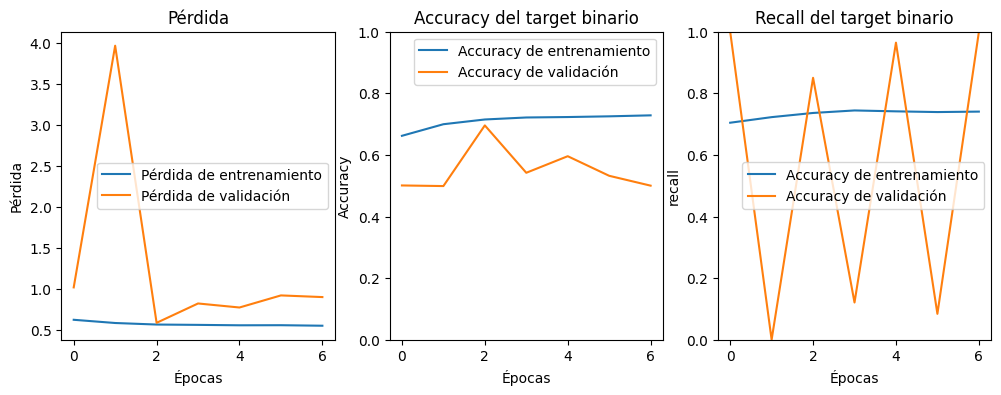

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_00_simple_clasif.csv')
plot_learning_curves(history_df_csv, type_g=1)

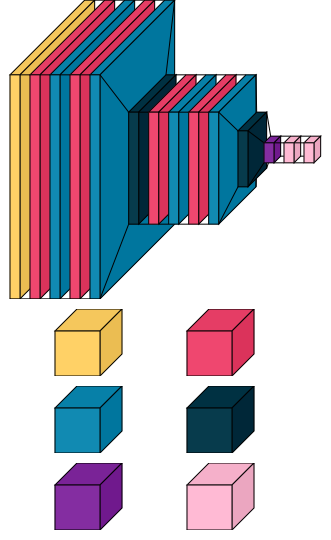

In [ ]:
# Cargar la fuente con el tamaño deseado
font = ImageFont.truetype(font_path, 40)

# Visualizar el modelo usando esta fuente
visualkeras.layered_view(model, legend=True, font=font, scale_xy=1, scale_z=1, max_z=10)

#### CNN3-FromScratch:

In [ ]:
def create_simple_classification_model_2():
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)


    # Aplanar la salida del encoder para la clasificación
    flatten = GlobalAveragePooling2D()(pool3)  # Aplanar la salida

    # Capas densas para la clasificación
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)  # Salida para clasificación binaria

    # Crear el modelo
    model = Model(inputs=[inputs], outputs=[target_output])

    return model

# Ejemplo de creación del modelo
model = create_simple_classification_model_2()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,2

 Total params: 297,121 (1.13 MB)

 Trainable params: 296,225 (1.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Ejemplo de creación del modelo
model = create_simple_classification_model()
model.summary()

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_00_simple_clasif_1.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_00_simple_clasif_1.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 79s 185ms/step - accuracy: 0.6480 - auroc: 0.6876 - loss: 0.6387 - precision_9: 0.6464 - recall_9: 0.6495 - val_accuracy: 0.6056 - val_auroc: 0.7564 - val_loss: 0.6631 - val_precision_9: 0.8035 - val_recall_9: 0.2806 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 63s 209ms/step - accuracy: 0.7072 - auroc: 0.7619 - loss: 0.5796 - precision_9: 0.6978 - recall_9: 0.7503 - val_accuracy: 0.7070 - val_auroc: 0.7684 - val_loss: 0.5828 - val_precision_9: 0.6733 - val_recall_9: 0.8066 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 63s 222ms/step - accuracy: 0.7089 - auroc: 0.7750 - loss: 0.5707 - precision_9: 0.6952 - recall_9: 0.7357 - val_accuracy: 0.7154 - val_auroc: 0.7822 - val_loss: 0.5659 - val_precision_9: 0.7231 - val_recall_9: 0.7027 - learning_rate: 0.0010
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 62s 219ms/step - accuracy: 0.7110 - auroc: 0.7775 - loss: 0.5674 - precision_9: 0.7083 - recall_9: 0.7221 - val_accur

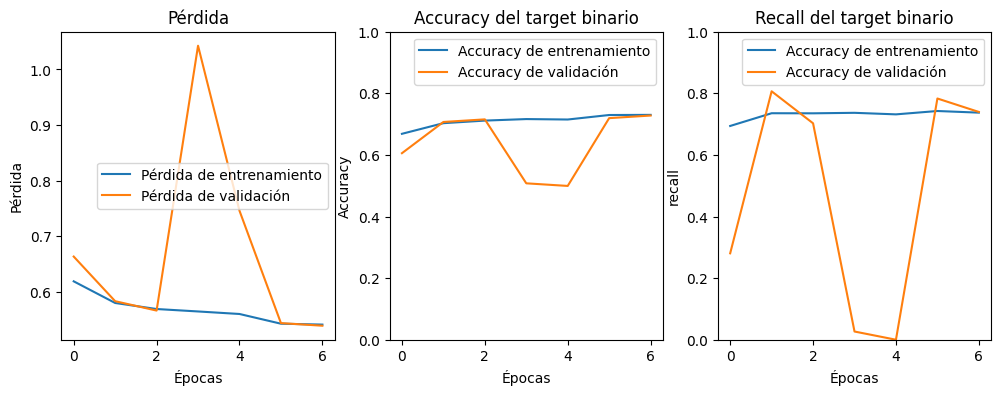

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_00_simple_clasif_1.csv')
plot_learning_curves(history_df_csv, type_g=1)

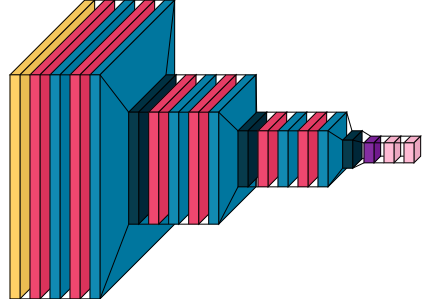

In [ ]:
#model=load_model(main_dir + "model_training/" +'model_00_simple_clasif_1.keras')
# Visualizar el modelo usando esta fuente
visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=10)

#### CNN5-FromScratch:

In [ ]:
def create_simpler_classification_model_4():
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Reducción de la rotación
    augmented = RandomZoom(0.2)(augmented)   # Reducción del zoom

    # Encoder con menos capas
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Aplanar la salida del encoder para la clasificación
    flatten = GlobalAveragePooling2D()(drop5)  # Aplanar la salida

    # Capas densas más simples
    dense = Dense(32, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)  # Salida binaria

    # Crear el modelo
    model = Model(inputs=[inputs], outputs=[target_output])

    return model
# Ejemplo de creación del modelo
model = create_simpler_classification_model_4()
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,732,513 (18.05 MB)

 Trainable params: 4,730,593 (18.05 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_07_simple_clasif_4.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_07_simple_clasif_4.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 119s 250ms/step - accuracy: 0.6296 - auroc: 0.6671 - loss: 0.7808 - precision_7: 0.6216 - recall_7: 0.6773 - val_accuracy: 0.6963 - val_auroc: 0.7671 - val_loss: 0.5966 - val_precision_7: 0.7584 - val_recall_7: 0.5770 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 71s 208ms/step - accuracy: 0.6985 - auroc: 0.7645 - loss: 0.5803 - precision_7: 0.6782 - recall_7: 0.7469 - val_accuracy: 0.7323 - val_auroc: 0.8045 - val_loss: 0.5398 - val_precision_7: 0.7261 - val_recall_7: 0.7480 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 85s 297ms/step - accuracy: 0.7225 - auroc: 0.7832 - loss: 0.5617 - precision_7: 0.7116 - recall_7: 0.7560 - val_accuracy: 0.6012 - val_auroc: 0.6825 - val_loss: 0.6661 - val_precision_7: 0.5638 - val_recall_7: 0.9115 - learning_rate: 0.0010
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 77s 269ms/step - accuracy: 0.7240 - auroc: 0.7918 - loss: 0.5527 - precision_7: 0.7111 - recall_7: 0.7512 - val_accu

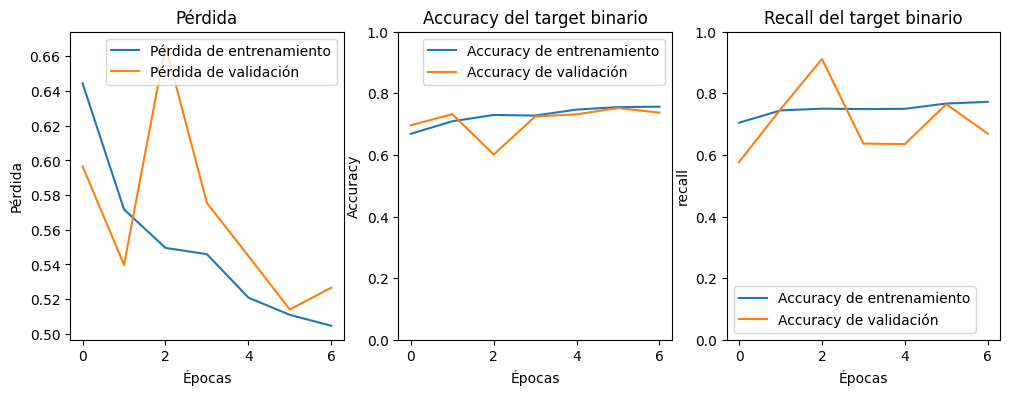

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_07_simple_clasif_4.csv')
plot_learning_curves(history_df_csv, type_g=1)

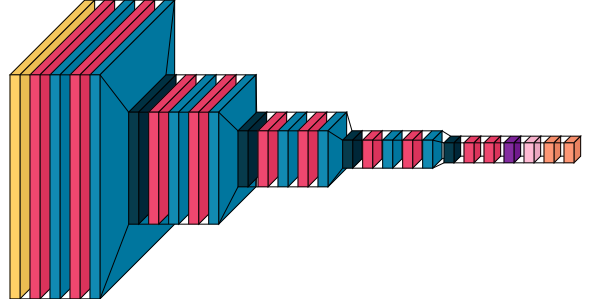

In [ ]:
model=load_model(main_dir + "model_training/" +'model_07_simple_clasif_4.keras')
# Visualizar el modelo usando esta fuente
visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=10)

#### Comparar

In [ ]:
lista_history_files=['history_00_simple_clasif.csv', #2 bloques CNN
                     'history_00_simple_clasif_1.csv', #3 bloques CNN
                     'history_07_simple_clasif_4.csv',  #4 bloques CNN
]
comparar_modelos(lista_history_files)

       Loss  Accuracy  Precision    Recall       AUC  \
0  0.898428  0.500222   0.499331  0.998216  0.779211   
1  0.538675  0.727879   0.721497  0.739518  0.804165   
2  0.526640  0.737217   0.773196  0.669046  0.832052   

                            Model  f1_score  
0    history_00_simple_clasif.csv  0.665675  
1  history_00_simple_clasif_1.csv  0.730396  
2  history_07_simple_clasif_4.csv  0.717360  


## 2 Transferlearning

### 2.1 Top Model

##### 2. MobilNet-Transferr-TopBN

In [ ]:
def create_backbone_classification_model_v2(backbone='ResNet50'):
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio


    # Seleccionar el backbone
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=augmented)
    else:
        raise ValueError("Backbone no soportado. Usa 'ResNet50', 'VGG16', 'MobileNetV2', 'DenseNet121' o 'InceptionV3'.")

    # Congelar las capas del backbone
    for layer in base_model.layers:
        layer.trainable = False

    #top_model
    # Conectar el backbone con la salida del modelo
    x = base_model(augmented)
    x = GlobalAveragePooling2D()(x)  # Aplanar la salida
    x = Dropout(0.3)(x)  # Regularización

    # Capas densas para la clasificación
    x = Dense(64, activation='relu')(x)  # Otra capa densa
    target_output = Dense(1, activation='sigmoid', name='target_output')(x)  # Salida para clasificación binaria
    # Crear el modelo
    model = Model(inputs=[inputs], outputs=[target_output])

    return model


In [ ]:
model = create_backbone_classification_model_v2(backbone='MobileNetV2')
model.summary()

<ipython-input-12-5905cd6b4a45>:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ target_output (Dense)                │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_04_mobilnet_clasif.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_model_04_mobilnet_clasif.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 460s 862ms/step - accuracy: 0.5072 - auroc: 0.5138 - loss: 0.7216 - precision: 0.5113 - recall: 0.5344 - val_accuracy: 0.7025 - val_auroc: 0.7872 - val_loss: 0.6037 - val_precision: 0.6434 - val_recall: 0.9094 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 46s 158ms/step - accuracy: 0.5030 - auroc: 0.4921 - loss: 0.6914 - precision: 0.5031 - recall: 0.4372 - val_accuracy: 0.6852 - val_auroc: 0.7905 - val_loss: 0.6104 - val_precision: 0.6235 - val_recall: 0.9388 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 57s 202ms/step - accuracy: 0.5009 - auroc: 0.5097 - loss: 0.6924 - precision: 0.5156 - recall: 0.3324 - val_accuracy: 0.7203 - val_auroc: 0.7913 - val_loss: 0.5589 - val_precision: 0.7309 - val_recall: 0.7018 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 57s 199ms/step - accuracy: 0.4988 - auroc: 0.5052 - loss: 0.6924 - precision: 0.4817 - recall: 0.1477 - val_accuracy: 0.6576 - val_auroc: 0.

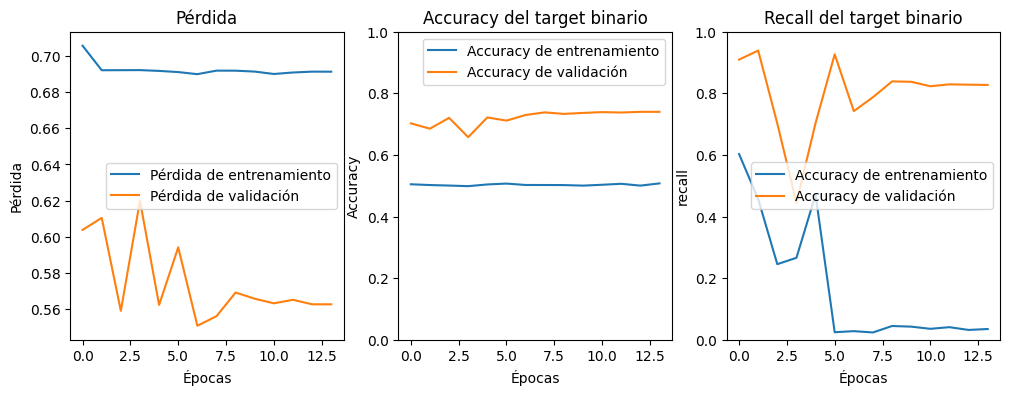

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_model_04_mobilnet_clasif.csv')
plot_learning_curves(history_df_csv, type_g=1)

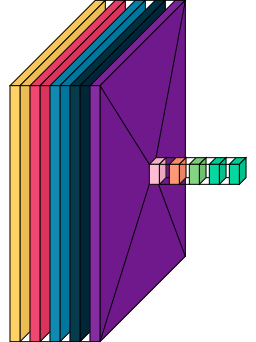

In [ ]:
model=load_model(main_dir + "model_training/" +'model_04_mobilnet_clasif.keras')
# Visualizar el modelo usando esta fuente
visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=10)

#### MobilNet-Transfer-TopFlatten

In [ ]:
def create_flatten(backbone='ResNet50'):
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio


    # Seleccionar el backbone
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=augmented)
    else:
        raise ValueError("Backbone no soportado. Usa 'ResNet50', 'VGG16', 'MobileNetV2', 'DenseNet121' o 'InceptionV3'.")

    # Congelar las capas del backbone
    for layer in base_model.layers:
        layer.trainable = False

    #top_model
    # Conectar el backbone con la salida del modelo
    x = base_model(augmented)
    x = Flatten()(x)  # Aplanar la salida

    # Capas densas para la clasificación
    x = Dense(64, activation='relu')(x)  # Otra capa densa
    target_output = Dense(1, activation='sigmoid', name='target_output')(x)  # Salida para clasificación binaria
    # Crear el modelo
    model = Model(inputs=[inputs], outputs=[target_output])

    return model

In [ ]:
model = create_flatten(backbone='MobileNetV2')
model.summary()

<ipython-input-15-ae149af10353>:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ target_output (Dense)                │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,272,193 (23.93 MB)

 Trainable params: 4,014,209 (15.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_00_flatten.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_00_flatten.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.6609 - auroc: 0.7122 - loss: 1.4132 - precision_3: 0.6599 - recall_3: 0.6571 - val_accuracy: 0.6774 - val_auroc: 0.7397 - val_loss: 0.6808 - val_precision_3: 0.6726 - val_recall_3: 0.6922 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.6846 - auroc: 0.7376 - loss: 0.8310 - precision_3: 0.6711 - recall_3: 0.7505 - val_accuracy: 0.7492 - val_auroc: 0.8231 - val_loss: 0.5220 - val_precision_3: 0.7463 - val_recall_3: 0.7569 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 54s 189ms/step - accuracy: 0.7507 - auroc: 0.8196 - loss: 0.5245 - precision_3: 0.7382 - recall_3: 0.7795 - val_accuracy: 0.7399 - val_auroc: 0.8266 - val_loss: 0.5257 - val_precision_3: 0.7669 - val_recall_3: 0.6929 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.7377 - auroc: 0.8103 - loss: 0.5337 - precision_3: 0.7321 - recall_3: 0.7430 - val_accurac

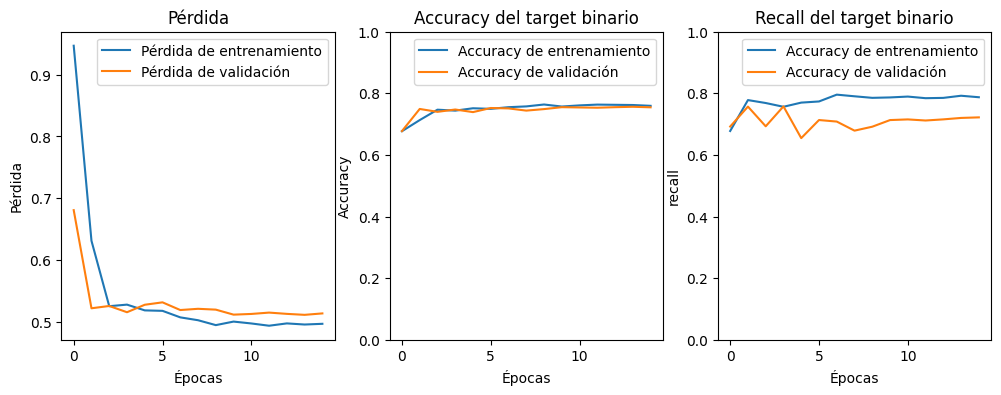

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_00_flatten.csv')
plot_learning_curves(history_df_csv, type_g=1)

#### Flatten mas capas

In [ ]:
def create_flatten_mas_capas(backbone='ResNet50'):
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio

    # Seleccionar el backbone
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=augmented)
    else:
        raise ValueError("Backbone no soportado. Usa 'ResNet50', 'VGG16', 'MobileNetV2', 'DenseNet121' o 'InceptionV3'.")

    # Congelar las capas del backbone
    for layer in base_model.layers:
        layer.trainable = False

    # Conectar el backbone con la salida del modelo
    x = base_model(augmented)
    x = Flatten()(x)  # Aplanar la salida

    # Añadir más capas densas y regularización
    x = Dense(64, activation='relu')(x)

    x = Dense(32, activation='relu')(x)

    # Capa final de salida para la clasificación binaria
    target_output = Dense(1, activation='sigmoid', name='target_output')(x)

    # Crear el modelo
    model = Model(inputs=[inputs], outputs=[target_output])

    return model


In [ ]:
model = create_flatten_mas_capas(backbone='MobileNetV2')
model.summary()

<ipython-input-83-33f1f903551c>:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_20 (RandomRotation)  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_20 (RandomZoom)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ target_output (Dense)                │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,274,241 (23.93 MB)

 Trainable params: 4,016,257 (15.32 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs = 5
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_00_flatten_mas_capas.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_00_flatten_mas_capas.csv', index=False)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 72s 159ms/step - accuracy: 0.6556 - auroc: 0.6919 - loss: 1.2658 - precision_11: 0.6473 - recall_11: 0.6679 - val_accuracy: 0.7254 - val_auroc: 0.8101 - val_loss: 0.5635 - val_precision_11: 0.6748 - val_recall_11: 0.8707 - learning_rate: 0.0010
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 53s 186ms/step - accuracy: 0.7157 - auroc: 0.7829 - loss: 0.5724 - precision_11: 0.7068 - recall_11: 0.7371 - val_accuracy: 0.7563 - val_auroc: 0.8259 - val_loss: 0.5225 - val_precision_11: 0.7729 - val_recall_11: 0.7276 - learning_rate: 0.0010
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 57s 200ms/step - accuracy: 0.7339 - auroc: 0.8018 - loss: 0.5455 - precision_11: 0.7251 - recall_11: 0.7325 - val_accuracy: 0.7550 - val_auroc: 0.8298 - val_loss: 0.5152 - val_precision_11: 0.7307 - val_recall_11: 0.8115 - learning_rate: 0.0010
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 57s 200ms/step - accuracy: 0.7213 - auroc: 0.7886 - loss: 0.5684 - precision_11: 0.7204 - recall_11: 0.7217 -

#### Comparar

In [ ]:
lista_history_files=['history_model_04_mobilnet_clasif.csv', #MobilNet-Transfer-TopBN
                     'history_00_flatten.csv', #MobilNet-Transfer-TopFlatten
                     'history_00_flatten_mas_capas.csv' #Flatten mas capas
]
comparar_modelos(lista_history_files)

       Loss  Accuracy  Precision    Recall       AUC  \
0  0.562509  0.739884   0.705438  0.827281  0.799761   
1  0.513669  0.754558   0.771429  0.721925  0.830199   
2  0.566446  0.717652   0.796856  0.585258  0.813184   

                                  Model  f1_score  
0  history_model_04_mobilnet_clasif.csv  0.761517  
1                history_00_flatten.csv  0.745856  
2      history_00_flatten_mas_capas.csv  0.674859  


### 2.2 Backbones

##### Mobilnet-Transfer

In [ ]:
model = create_flatten(backbone='MobileNetV2')
model.summary()

<ipython-input-15-ae149af10353>:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ target_output (Dense)                │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,272,193 (23.93 MB)

 Trainable params: 4,014,209 (15.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_00_flatten.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_00_flatten.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.6609 - auroc: 0.7122 - loss: 1.4132 - precision_3: 0.6599 - recall_3: 0.6571 - val_accuracy: 0.6774 - val_auroc: 0.7397 - val_loss: 0.6808 - val_precision_3: 0.6726 - val_recall_3: 0.6922 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.6846 - auroc: 0.7376 - loss: 0.8310 - precision_3: 0.6711 - recall_3: 0.7505 - val_accuracy: 0.7492 - val_auroc: 0.8231 - val_loss: 0.5220 - val_precision_3: 0.7463 - val_recall_3: 0.7569 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 54s 189ms/step - accuracy: 0.7507 - auroc: 0.8196 - loss: 0.5245 - precision_3: 0.7382 - recall_3: 0.7795 - val_accuracy: 0.7399 - val_auroc: 0.8266 - val_loss: 0.5257 - val_precision_3: 0.7669 - val_recall_3: 0.6929 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.7377 - auroc: 0.8103 - loss: 0.5337 - precision_3: 0.7321 - recall_3: 0.7430 - val_accurac

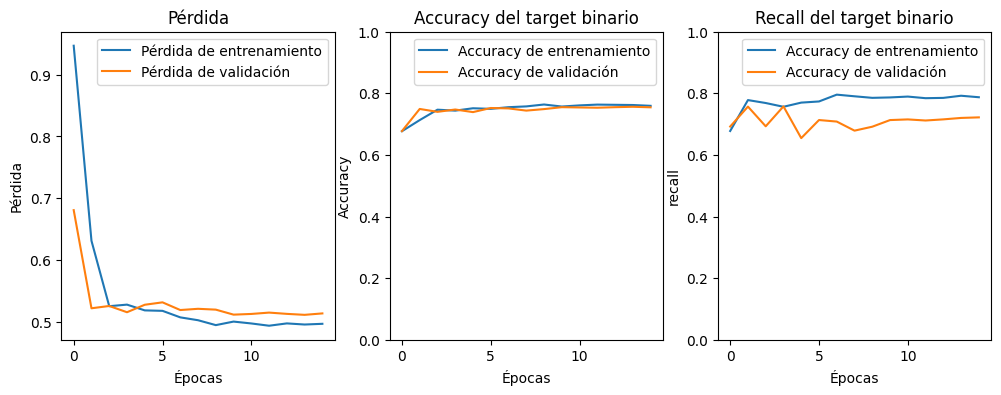

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_00_flatten.csv')
plot_learning_curves(history_df_csv, type_g=1)

#### ResNet-Transfer

In [ ]:
model=create_flatten(backbone='ResNet50')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
epochs = 3
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_01_resnet_clasif_flatten.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_01_resnet_clasif_flatten.csv', index=False)

Epoch 1/3
285/285 ━━━━━━━━━━━━━━━━━━━━ 90s 212ms/step - accuracy: 0.4946 - auroc: 0.5006 - loss: 1.4993 - precision_12: 0.4927 - recall_12: 0.7795 - val_accuracy: 0.5004 - val_auroc: 0.5000 - val_loss: 0.6931 - val_precision_12: 0.5004 - val_recall_12: 1.0000 - learning_rate: 0.0010
Epoch 2/3
285/285 ━━━━━━━━━━━━━━━━━━━━ 67s 235ms/step - accuracy: 0.4947 - auroc: 0.4998 - loss: 0.6932 - precision_12: 0.4896 - recall_12: 0.5341 - val_accuracy: 0.5011 - val_auroc: 0.5000 - val_loss: 0.6931 - val_precision_12: 0.5011 - val_recall_12: 1.0000 - learning_rate: 0.0010
Epoch 3/3
285/285 ━━━━━━━━━━━━━━━━━━━━ 68s 240ms/step - accuracy: 0.4942 - auroc: 0.4999 - loss: 0.6932 - precision_12: 0.4938 - recall_12: 0.8542 - val_accuracy: 0.5024 - val_auroc: 0.5000 - val_loss: 0.6931 - val_precision_12: 0.5024 - val_recall_12: 1.0000 - learning_rate: 0.0010


#### DenseNet-Transfer

In [ ]:
model=create_flatten(backbone='DenseNet121')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_10_densnet_clasif_flatten.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_10_densnet_clasif_flatten.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 158s 430ms/step - accuracy: 0.6762 - auroc: 0.6999 - loss: 1.3131 - precision_6: 0.6764 - recall_6: 0.6722 - val_accuracy: 0.7364 - val_auroc: 0.7630 - val_loss: 0.5889 - val_precision_6: 0.7004 - val_recall_6: 0.8267 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 62s 214ms/step - accuracy: 0.7337 - auroc: 0.7796 - loss: 0.5836 - precision_6: 0.7184 - recall_6: 0.7626 - val_accuracy: 0.7390 - val_auroc: 0.7831 - val_loss: 0.5674 - val_precision_6: 0.7030 - val_recall_6: 0.8296 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 69s 242ms/step - accuracy: 0.7397 - auroc: 0.7867 - loss: 0.5659 - precision_6: 0.7160 - recall_6: 0.7949 - val_accuracy: 0.7305 - val_auroc: 0.8181 - val_loss: 0.5720 - val_precision_6: 0.7793 - val_recall_6: 0.6469 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.7494 - auroc: 0.7968 - loss: 0.5521 - precision_6: 0.7377 - recall_6: 0.7957 - val_accu

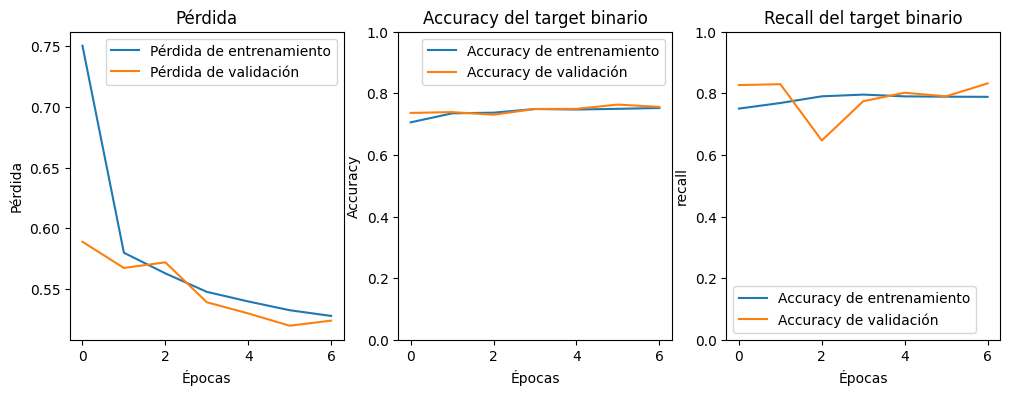

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_10_densnet_clasif_flatten.csv')
plot_learning_curves(history_df_csv, type_g=1)

#### Inception-Transfer

In [ ]:
model=create_flatten(backbone='InceptionV3')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.0005

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_11_inception_clasif_flatten.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_11_inception_clasif_flatten.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 80s 179ms/step - accuracy: 0.6554 - auroc: 0.6890 - loss: 1.4082 - precision_7: 0.6480 - recall_7: 0.6605 - val_accuracy: 0.6607 - val_auroc: 0.7885 - val_loss: 0.6945 - val_precision_7: 0.8339 - val_recall_7: 0.4019 - learning_rate: 5.0000e-04
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 57s 197ms/step - accuracy: 0.6996 - auroc: 0.7665 - loss: 0.6425 - precision_7: 0.6978 - recall_7: 0.7012 - val_accuracy: 0.6527 - val_auroc: 0.7942 - val_loss: 0.7259 - val_precision_7: 0.8379 - val_recall_7: 0.3807 - learning_rate: 5.0000e-04
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 58s 203ms/step - accuracy: 0.7141 - auroc: 0.7809 - loss: 0.6206 - precision_7: 0.7176 - recall_7: 0.7027 - val_accuracy: 0.6807 - val_auroc: 0.7895 - val_loss: 0.6416 - val_precision_7: 0.6267 - val_recall_7: 0.9018 - learning_rate: 5.0000e-04
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 58s 205ms/step - accuracy: 0.7216 - auroc: 0.7849 - loss: 0.5978 - precision_7: 0.7234 - recall_7: 0.7220

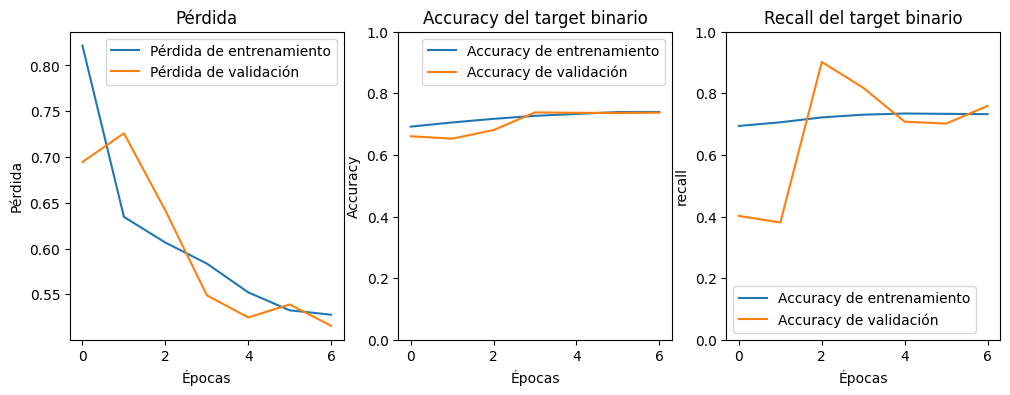

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_11_inception_clasif_flatten.csv')
plot_learning_curves(history_df_csv, type_g=1)

#### VGG16-Transfer

In [ ]:
model=create_flatten(backbone='VGG16')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_02_VGG16_clasif_flatten.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_02_VGG16_clasif_flatten.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 81s 195ms/step - accuracy: 0.6400 - auroc: 0.7016 - loss: 0.6959 - precision_8: 0.6214 - recall_8: 0.7178 - val_accuracy: 0.7328 - val_auroc: 0.8138 - val_loss: 0.5626 - val_precision_8: 0.7958 - val_recall_8: 0.6271 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 76s 265ms/step - accuracy: 0.7254 - auroc: 0.7840 - loss: 0.5599 - precision_8: 0.7177 - recall_8: 0.7424 - val_accuracy: 0.7430 - val_auroc: 0.8241 - val_loss: 0.5181 - val_precision_8: 0.7471 - val_recall_8: 0.7365 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 80s 282ms/step - accuracy: 0.7242 - auroc: 0.7965 - loss: 0.5480 - precision_8: 0.7169 - recall_8: 0.7406 - val_accuracy: 0.7243 - val_auroc: 0.8252 - val_loss: 0.5501 - val_precision_8: 0.7993 - val_recall_8: 0.6027 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 73s 257ms/step - accuracy: 0.7321 - auroc: 0.8017 - loss: 0.5395 - precision_8: 0.7141 - recall_8: 0.7647 - val_accur

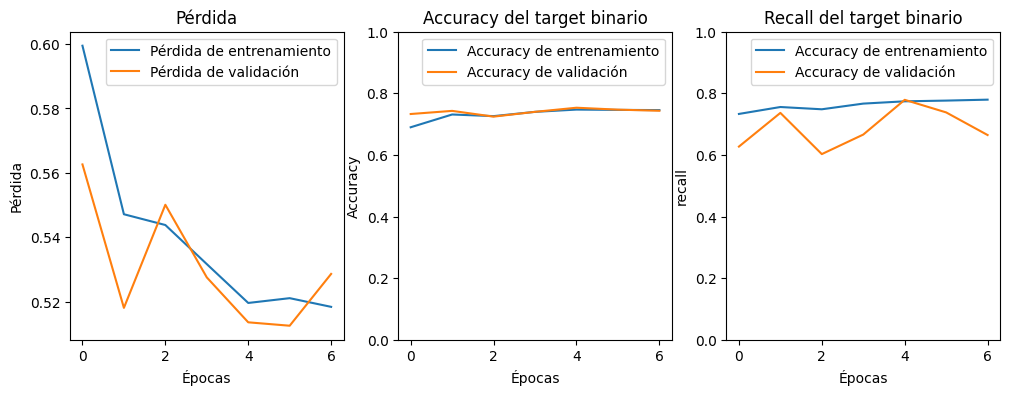

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_02_VGG16_clasif_flatten.csv')
plot_learning_curves(history_df_csv, type_g=1)

#### Comparar

In [ ]:
lista_history_files=['history_00_flatten.csv', #Mobilnet-Transfer
                     'history_01_resnet_clasif_flatten.csv', #ResNet-Transfer
                     'history_10_densnet_clasif_flatten.csv', #DenseNet-Transfer
                     'history_11_inception_clasif_flatten.csv', #Inception-Transfer
                     'history_02_VGG16_clasif_flatten.csv']   #VGG16-Transfer
comparar_modelos(lista_history_files)


       Loss  Accuracy  Precision    Recall       AUC  \
0  0.513669  0.754558   0.771429  0.721925  0.830199   
1  0.693135  0.502446   0.502446  1.000000  0.500000   
2  0.524085  0.755892   0.721020  0.832293  0.817979   
3  0.515722  0.737217   0.726109  0.759144  0.828168   
4  0.528638  0.743442   0.787526  0.664585  0.828451   

                                     Model  f1_score  
0                   history_00_flatten.csv  0.745856  
1     history_01_resnet_clasif_flatten.csv  0.668837  
2    history_10_densnet_clasif_flatten.csv  0.772671  
3  history_11_inception_clasif_flatten.csv  0.742259  
4      history_02_VGG16_clasif_flatten.csv  0.720851  


## 3  FineTuning

In [ ]:
def create_backbone_classification_model_v3(backbone='ResNet50',
                                            freeze_layers=True, n_layers_to_unfreeze=3):
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio



    # Seleccionar el backbone
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=augmented)
    else:
        raise ValueError("Backbone no soportado. Usa 'ResNet50', 'VGG16', 'MobileNetV2', 'DenseNet121' o 'InceptionV3'.")

    # Congelar las capas del backbone
    if freeze_layers:
        for layer in base_model.layers:
            layer.trainable = False

    # Descongelar las últimas n capas
    for layer in base_model.layers[-n_layers_to_unfreeze:]:
        layer.trainable = True


    #top_model
    # Conectar el backbone con la salida del modelo
    x = base_model(augmented)
    x = Flatten()(x)  # Aplanar la salida


    # Capas densas para la clasificación
    x = Dense(64, activation='relu')(x)  # Otra capa densa
    target_output = Dense(1, activation='sigmoid', name='target_output')(x)  # Salida para clasificación binaria
    # Crear el modelo
    model = Model(inputs=[inputs], outputs=[target_output])

    return model


##### MobileNet-FineTuned-3

In [ ]:
model = create_backbone_classification_model_v3('MobileNetV2', True, 3)
model.summary()

<ipython-input-21-e4a9dd68b0a0>:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_23 (RandomRotation)  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_23 (RandomZoom)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ target_output (Dense)                │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,272,193 (23.93 MB)

 Trainable params: 4,426,369 (16.89 MB)

 Non-trainable params: 1,845,824 (7.04 MB)

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_05_mobilnet_clasif.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_model_05_mobilnet_clasif.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 74s 165ms/step - accuracy: 0.6976 - auroc: 0.7369 - loss: 1.0029 - precision_3: 0.6882 - recall_3: 0.7265 - val_accuracy: 0.7386 - val_auroc: 0.8115 - val_loss: 0.5413 - val_precision_3: 0.7891 - val_recall_3: 0.6517 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 55s 193ms/step - accuracy: 0.7285 - auroc: 0.7909 - loss: 0.5642 - precision_3: 0.7291 - recall_3: 0.7306 - val_accuracy: 0.7586 - val_auroc: 0.8267 - val_loss: 0.5148 - val_precision_3: 0.7561 - val_recall_3: 0.7649 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 58s 204ms/step - accuracy: 0.7495 - auroc: 0.8218 - loss: 0.5191 - precision_3: 0.7375 - recall_3: 0.7627 - val_accuracy: 0.7488 - val_auroc: 0.8310 - val_loss: 0.5075 - val_precision_3: 0.7862 - val_recall_3: 0.6867 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 58s 204ms/step - accuracy: 0.7510 - auroc: 0.8278 - loss: 0.5102 - precision_3: 0.7579 - recall_3: 0.7257 - val_accur

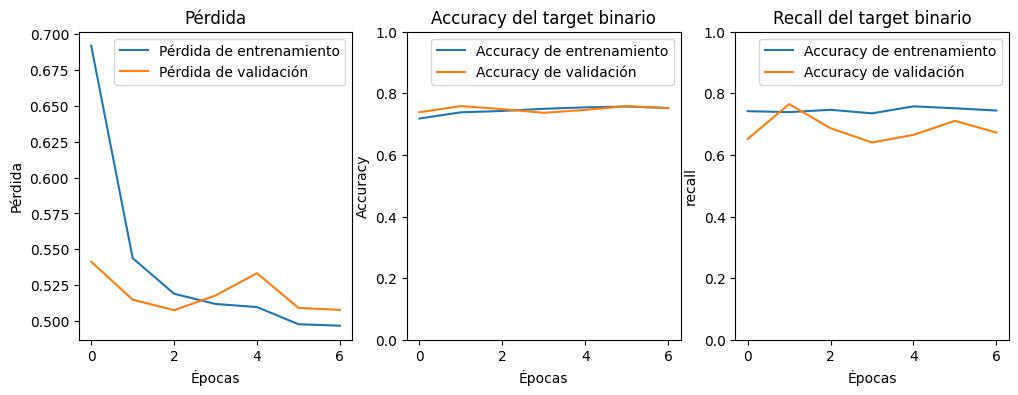

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_model_05_mobilnet_clasif.csv')
plot_learning_curves(history_df_csv, type_g=1)

##### MobileNet-FineTuned-ALL

In [ ]:
def create_backbone_classification_model_v5(backbone='ResNet50'):
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio



    # Seleccionar el backbone
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=augmented)
    else:
        raise ValueError("Backbone no soportado. Usa 'ResNet50', 'VGG16', 'MobileNetV2', 'DenseNet121' o 'InceptionV3'.")

    # Conectar el backbone con la salida del modelo
    #top_model
    # Conectar el backbone con la salida del modelo
    x = base_model(augmented)
    x = Flatten()(x)  # Aplanar la salida


    # Capas densas para la clasificación
    x = Dense(64, activation='relu')(x)  # Otra capa densa
    target_output = Dense(1, activation='sigmoid', name='target_output')(x)  # Salida para clasificación binaria
    # Crear el modelo
    model = Model(inputs=[inputs], outputs=[target_output])

    return model

In [ ]:
model = create_backbone_classification_model_v5('MobileNetV2')
model.summary()

<ipython-input-8-2e80d9b2dd43>:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ target_output (Dense)                │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,272,193 (23.93 MB)

 Trainable params: 6,238,081 (23.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_sin_mascara ,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_sin_mascara,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_11_mobil_clasif_total_descong.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_11_mobil_clasif_total_descong.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 387s 758ms/step - accuracy: 0.6618 - auroc: 0.7201 - loss: 0.8427 - precision_2: 0.6579 - recall_2: 0.6654 - val_accuracy: 0.5004 - val_auroc: 0.5000 - val_loss: 0.6933 - val_precision_2: 0.5004 - val_recall_2: 1.0000 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 83s 288ms/step - accuracy: 0.7379 - auroc: 0.8149 - loss: 0.5325 - precision_2: 0.7205 - recall_2: 0.7821 - val_accuracy: 0.6843 - val_auroc: 0.7218 - val_loss: 0.7023 - val_precision_2: 0.6805 - val_recall_2: 0.6974 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 391ms/step - accuracy: 0.7436 - auroc: 0.8153 - loss: 0.5282 - precision_2: 0.7277 - recall_2: 0.7724 - val_accuracy: 0.5051 - val_auroc: 0.5047 - val_loss: 0.7019 - val_precision_2: 0.5038 - val_recall_2: 0.9938 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 103s 362ms/step - accuracy: 0.7685 - auroc: 0.8397 - loss: 0.4948 - precision_2: 0.7417 - recall_2: 0.8168 - val_ac

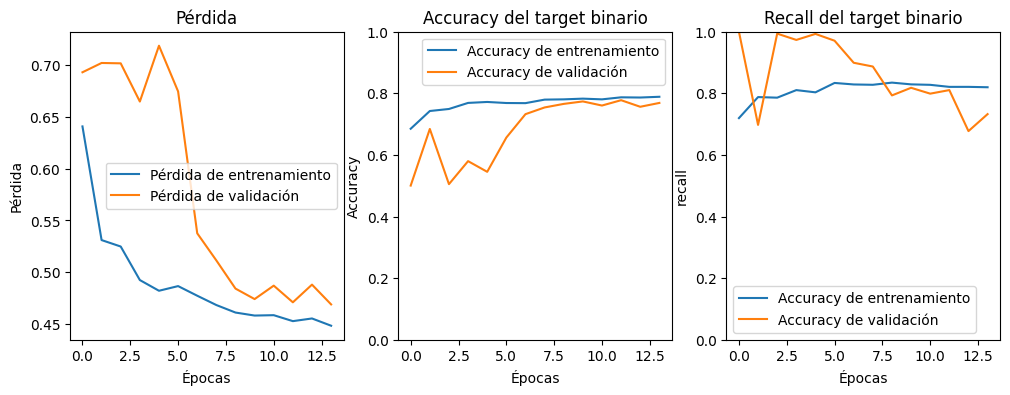

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_11_mobil_clasif_total_descong.csv')
plot_learning_curves(history_df_csv, type_g=1)

##### Comparar

In [ ]:
lista_history_files=['history_00_flatten.csv', #MobilNet-Transfer
                     'history_model_05_mobilnet_clasif.csv', #MobileNet-FineTuned-3
                     'history_11_mobil_clasif_total_descong.csv' #MobileNet-FineTuned-ALL
                     ]
comparar_modelos(lista_history_files)


       Loss  Accuracy  Precision    Recall       AUC  \
0  0.513669  0.754558   0.771429  0.721925  0.830199   
1  0.507668  0.751445   0.797040  0.672614  0.837437   
2  0.468785  0.768786   0.791388  0.732507  0.858781   

                                       Model  f1_score  
0                     history_00_flatten.csv  0.745856  
1       history_model_05_mobilnet_clasif.csv  0.729560  
2  history_11_mobil_clasif_total_descong.csv  0.760810  


## 4 Integración de Variables Numéricas Adicionales

#### Mobilnet-Transfer-Concat

In [ ]:
def create_var_concat_class_model(backbone='ResNet50'):
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Entrada para las variables numéricas
    var_input = Input(shape=(3,))  # Entrada de variables adicionales

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio


    # Seleccionar el backbone
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=augmented)
    else:
        raise ValueError("Backbone no soportado. Usa 'ResNet50', 'VGG16', 'MobileNetV2', 'DenseNet121' o 'InceptionV3'.")

    # Congelar las capas del backbone
    for layer in base_model.layers:
        layer.trainable = False

    # Conectar el backbone con la salida del modelo
    x = base_model(augmented)
    x = Flatten()(x)  # Aplanar la salida

    # Capas densas para la clasificación
    x = Dense(64, activation='relu')(x)

    # Concatenar la salida de la imagen con las variables numéricas
    combined = concatenate([x, var_input])

    target_output = Dense(1, activation='sigmoid', name='target_output')(combined)  # Salida para clasificación binaria

    # Crear el modelo
    model = Model(inputs=[inputs,var_input], outputs=[target_output])

    return model

In [ ]:
model = create_var_concat_class_model(backbone='MobileNetV2')
#model.summary()

<ipython-input-35-a8324b9b057b>:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_num_var,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_num_var,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr] )

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_06_mobilnet_var_num.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_model_06_mobilnet_var_num.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 66s 194ms/step - accuracy: 0.6668 - auroc: 0.7136 - loss: 1.5330 - precision_5: 0.6509 - recall_5: 0.7222 - val_accuracy: 0.6857 - val_auroc: 0.8151 - val_loss: 0.6229 - val_precision_5: 0.6236 - val_recall_5: 0.9384 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 53s 186ms/step - accuracy: 0.7333 - auroc: 0.8031 - loss: 0.5417 - precision_5: 0.7269 - recall_5: 0.7543 - val_accuracy: 0.7506 - val_auroc: 0.8295 - val_loss: 0.5180 - val_precision_5: 0.7721 - val_recall_5: 0.7125 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 53s 187ms/step - accuracy: 0.7359 - auroc: 0.8106 - loss: 0.5346 - precision_5: 0.7226 - recall_5: 0.7714 - val_accuracy: 0.7554 - val_auroc: 0.8296 - val_loss: 0.5067 - val_precision_5: 0.7397 - val_recall_5: 0.7920 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 52s 182ms/step - accuracy: 0.7487 - auroc: 0.8207 - loss: 0.5195 - precision_5: 0.7369 - recall_5: 0.7811 - val_accur

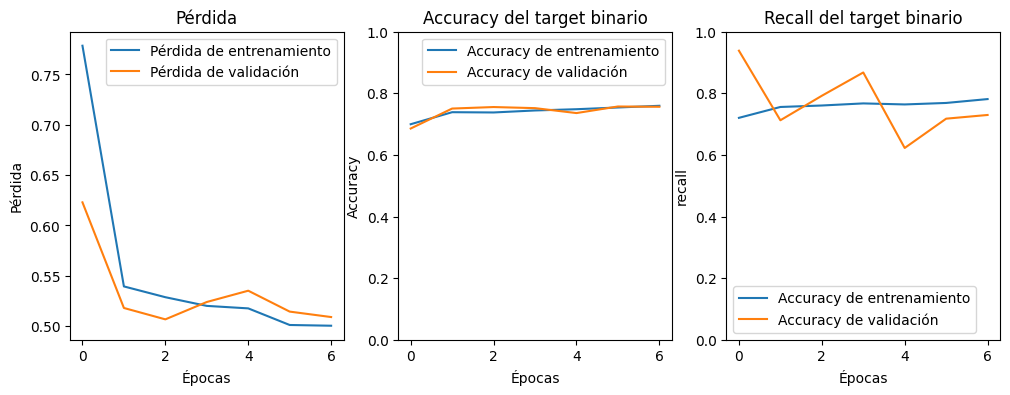

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_model_06_mobilnet_var_num.csv')
plot_learning_curves(history_df_csv, type_g=1)

#### Mobilnet-Transfer-Rama

In [ ]:
def create_var_rama_class_model(backbone='ResNet50'):
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Entrada para las variables numéricas
    var_input = Input(shape=(3,))  # Entrada de variables adicionales

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio

    # Seleccionar el backbone
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=augmented)
    else:
        raise ValueError("Backbone no soportado. Usa 'ResNet50', 'VGG16', 'MobileNetV2', 'DenseNet121' o 'InceptionV3'.")

    # Congelar las capas del backbone
    for layer in base_model.layers:
        layer.trainable = False

    # Conectar el backbone con la salida del modelo
    x = base_model(augmented)
    x = Flatten()(x)  # Aplanar la salida
    x = Dense(64, activation='relu')(x)


    # Procesar las variables numéricas
    var_processed = Dense(32, activation='relu')(var_input)  # Primera capa densa
    var_processed = Dropout(0.3)(var_processed)  # Regularización
    var_processed = Dense(16, activation='relu')(var_processed)  # Segunda capa densa

    # Concatenar la salida de la imagen con las variables numéricas procesadas
    combined = concatenate([x, var_processed])

    target_output = Dense(1, activation='sigmoid', name='target_output')(combined)  # Salida para clasificación binaria

    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[target_output])

    return model

In [ ]:
model = create_var_rama_class_model(backbone='MobileNetV2')
#model.summary()

<ipython-input-42-6fe2a5e4a495>:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_num_var,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_num_var,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_07_mobilnet_rama_num.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_model_07_mobilnet_rama_num.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 62s 180ms/step - accuracy: 0.6725 - auroc: 0.7100 - loss: 1.2043 - precision_6: 0.6626 - recall_6: 0.7079 - val_accuracy: 0.7509 - val_auroc: 0.8222 - val_loss: 0.5174 - val_precision_6: 0.7319 - val_recall_6: 0.7924 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.7355 - auroc: 0.8068 - loss: 0.5324 - precision_6: 0.7029 - recall_6: 0.8088 - val_accuracy: 0.7474 - val_auroc: 0.8245 - val_loss: 0.5205 - val_precision_6: 0.7103 - val_recall_6: 0.8376 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 53s 185ms/step - accuracy: 0.7349 - auroc: 0.8050 - loss: 0.5425 - precision_6: 0.7189 - recall_6: 0.7669 - val_accuracy: 0.7452 - val_auroc: 0.8238 - val_loss: 0.5244 - val_precision_6: 0.7600 - val_recall_6: 0.7204 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 51s 181ms/step - accuracy: 0.7463 - auroc: 0.8238 - loss: 0.5144 - precision_6: 0.7318 - recall_6: 0.7822 - val_accur

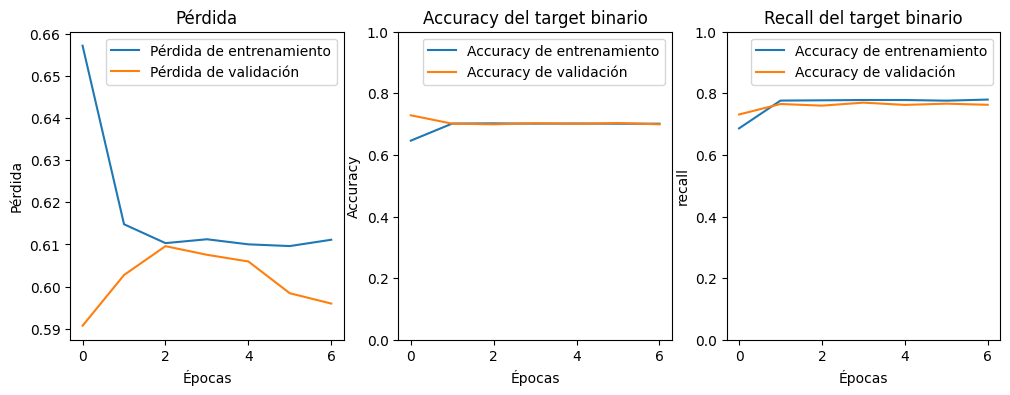

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_model_07_mobilnet_rama_num.csv')
plot_learning_curves(history_df_csv, type_g=1)

#### Comparar

In [ ]:
lista_history_files=['history_00_flatten.csv', #MobilNet-Transfer
                     'history_model_06_mobilnet_var_num.csv',  #MobilNet-Transfer-Concat
                     'history_model_07_mobilnet_rama_num.csv'] #MobilNet-Transfer-Rama
comparar_modelos(lista_history_files)


       Loss  Accuracy  Precision    Recall       AUC  \
0  0.513669  0.754558   0.771429  0.721925  0.830199   
1  0.509007  0.756336   0.769520  0.729706  0.833746   
2  0.520824  0.748333   0.763033  0.718109  0.828421   

                                    Model  
0                  history_00_flatten.csv  
1   history_model_06_mobilnet_var_num.csv  
2  history_model_07_mobilnet_rama_num.csv  


## Modelo Final para Clasificación


### MobilNet-Hybrid

In [ ]:
def create_exp_1(backbone='ResNet50'):
    # Entrada
    inputs = Input(shape=(image_size, image_size, 3))

    # Entrada para las variables numéricas
    var_input = Input(shape=(3,))  # Entrada de variables adicionales

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio



    # Seleccionar el backbone
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=augmented)
    else:
        raise ValueError("Backbone no soportado. Usa 'ResNet50', 'VGG16', 'MobileNetV2', 'DenseNet121' o 'InceptionV3'.")

    # Conectar el backbone con la salida del modelo
    x = base_model(augmented)
    x = Flatten()(x)  # Aplanar la salida

    # Capas densas para la clasificación
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)  # Aplicar Batch Normalization
    x = Activation('relu')(x)  # Luego aplicar la activación
    # Concatenar la salida de la imagen con las variables numéricas
    combined = concatenate([x, var_input])

    target_output = Dense(1, activation='sigmoid', name='target_output')(combined)  # Salida para clasificación binaria
    model = Model(inputs=[inputs, var_input], outputs=[target_output])

    return model

In [ ]:
model = create_exp_1(backbone='MobileNetV2')
model.summary()

<ipython-input-28-bfbfb11122ad>:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=augmented)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_1         │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_1             │ (None, 224, 224, 3)    │              0 │ random_rotation_1[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ random_zoom_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 62720)          │              0 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │      4,014,144 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 67)             │              0 │ activation_1[0][0],    │
│ (Concatenate)             │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_output (Dense)     │ (None, 1)              │             68 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,272,452 (23.93 MB)

 Trainable params: 6,238,212 (23.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.0005

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

# Entrenamiento del modelo
history = model.fit(train_dataset_num_var,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset_num_var,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr] )

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_exp.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history__exp.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 343s 1000ms/step - accuracy: 0.6868 - auroc: 0.7428 - loss: 0.6648 - precision: 0.6826 - recall: 0.6970 - val_accuracy: 0.5251 - val_auroc: 0.8007 - val_loss: 1.2942 - val_precision: 0.5131 - val_recall: 0.9982 - learning_rate: 5.0000e-04
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 87s 302ms/step - accuracy: 0.7157 - auroc: 0.7881 - loss: 0.5597 - precision: 0.7024 - recall: 0.7506 - val_accuracy: 0.6812 - val_auroc: 0.8055 - val_loss: 0.6026 - val_precision: 0.6206 - val_recall: 0.9361 - learning_rate: 5.0000e-04
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 94s 331ms/step - accuracy: 0.7587 - auroc: 0.8347 - loss: 0.5043 - precision: 0.7397 - recall: 0.7973 - val_accuracy: 0.6910 - val_auroc: 0.8085 - val_loss: 0.6156 - val_precision: 0.6286 - val_recall: 0.9407 - learning_rate: 5.0000e-04
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 85s 297ms/step - accuracy: 0.7702 - auroc: 0.8493 - loss: 0.4854 - precision: 0.7491 - recall: 0.8089 - val_accuracy: 0.7550 - 

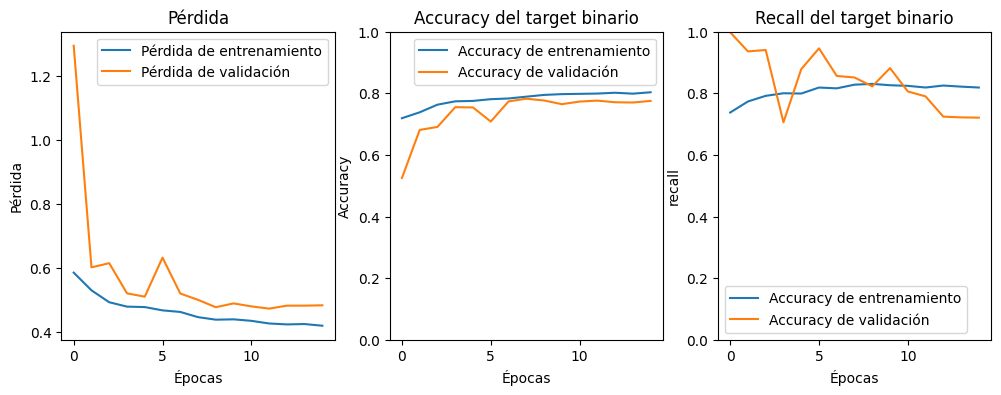

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history__exp.csv')
plot_learning_curves(history_df_csv, type_g=1)

In [ ]:
lista_history_files=['history_00_simple_clasif.csv',
                     'history__exp.csv'
                     ]
comparar_modelos(lista_history_files)

       Loss  Accuracy  Precision    Recall       AUC  \
0  0.898428  0.500222   0.499331  0.998216  0.779211   
1  0.484089  0.775456   0.808192  0.721034  0.859346   

                          Model  f1_score  
0  history_00_simple_clasif.csv  0.665675  
1              history__exp.csv  0.762129  


### Evaluar en Test

In [ ]:
model='model_exp.keras'
model_dir = main_dir + "model_training/"
model_1 = load_model(model_dir + model)
model_1.evaluate(test_dataset_num_var)

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7777 - auroc: 0.8699 - loss: 0.4608 - precision: 0.7787 - recall: 0.7883


[0.4718029797077179,
 0.7687187790870667,
 0.7571884989738464,
 0.7900000214576721,
 0.8590420484542847]